In [1]:
%config Completer.use_jedi = False

In [2]:
import os
import sys
import random
import collections

In [3]:
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mlp
from PIL import Image

In [4]:
import torch
import torchvision
from torchvision import transforms as T
from torch.utils.data import Dataset, DataLoader
from torch.utils.data import random_split
from torch.utils.data import SubsetRandomSampler, WeightedRandomSampler

In [5]:
# Set random seed
SEED = 777
random.seed(SEED)
np.random.seed(SEED)
os.environ["PYTHONHASHSEED"] = str(SEED)
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = True

In [6]:
print(f"CUDA: {torch.cuda.is_available()}")
print(f"torch Version: {torch.__version__}")
print(f"torchvision Version: {torchvision.__version__}")

CUDA: True
torch Version: 1.9.0+cu111
torchvision Version: 0.10.0+cu111


# Dataset 설계
## 기능별 분류
Dataset에서 구현해야하는 기능은 크게 3가지다.
1. 마스크  
- 마스크는 바르게 씀, 이상하게 씀, 안 씀, 세가지 클래스를 분류해야한다.
- 따라서 DataFrame에서 path를 받아오고 디렉토리로 접근하여 `mask1~5, normal, incorrect_mask` 를 가져온다.
- 이때 파일의 이름이 클래스가 되고 파일의 이름이 `mask1~5`에 속한다면 `mask`로 통일할 수 있다.
- Anomaly detection 을 위해서는 `mask`라벨을 제외한 다른 라벨이 abnormal이 된다.
2. 성별  
- 성별 데이터는 DataFrame에서 `gender`를 뽑아온다.
- class는 `female, male` 두가지가 있으며 정수 `0, 1`로 mapping하여 사용한다.
- 나머지 항목은 영향을 주지 않는다.
3. 나이  
- 나이는 DataFrame에서 `Age`열을 가져 온다.
- 이때 `AgeBand`열을 추가로 만들어서 좀 더 다루기 쉽도록 한다.
- `AgeBand`는 `30세 미만, 30세 이상 60세 미만, 60세 이상`으로 구성된다.
- 각각의 label은 `0, 1, 2`의 벡터로 맵핑 될 수 있다.
- Anomaly detector를 위해서는 `60세 미만, 60세 이상`으로 구분하여 `60세 이상`의 경우 abnormal으로 취급할 수 있다.

하나씩 해보자.

In [23]:
# torch.utils.data.Dataset
class MaskDataset(Dataset):
    def __init__(
        self,
        mode : str,
        train : bool = True,
        csv_path : str = "./train/train.csv",
        images_path : str = "./train/images/",
        valid_ratio : float = 0.1,
        transforms : T.Compose = None,
    ):
        
        self.mode = mode
        self.transforms = transforms
        
        df = pd.read_csv(csv_path)
        #df = df.sample(len(df)) # shuffle
        
        #= Gender to number ====================================
        df["GenderNum"] = df["gender"].map({"female" : 0, "male" : 1})
        #=======================================================
        
        #= AgeBand to number ===================================
        df["AgeBand"] = pd.cut(
            df["age"],
            bins = [df["age"].min(),30,df["age"].max(),100],
            right=False,
            labels = [0, 1, 2]
        )
        #=======================================================
        
        #= Split ===============================================
        if self.mode != "only_normal":
            split = int(len(df)*valid_ratio)
            df = df[:split] if train else df[split:]
        #=======================================================
        
        #= Mode Selection ======================================
        if mode == "mask_label":
            self.X, self.y = self.mask_label(df)
        elif mode == "only_normal":
            self.X, self.y = self.only_normal(df)
        #=======================================================
        
    def mask_label(self,df):
        #= Mask : Mask, Correct, Incorrect =====================
        total_im_path, mask_label = [], []
        for path in df["path"]:
            path = "./train/images/" + path + "/"
            for im_name in os.listdir(path):
                if not im_name.startswith("."):
                    # image path
                    total_im_path.append(path + im_name)
                    # label
                    if re.search("normal", im_name):
                        mask_label.append(1)
                    elif re.search("incorrect_mask", im_name):
                        mask_label.append(2)
                    else: # re.search("mask[1-5]", im_name):
                        mask_label.append(0)
        return total_im_path, mask_label
        #=======================================================
        
    def only_normal(self,df):
        #= No label ============================================
        total_im_path = []
        for path in df["path"]:
            path = "./train/images/" + path + "/"
            for im_name in os.listdir(path):
                if not im_name.startswith(".") and\
                re.search("normal", im_name):
                    # image path
                    total_im_path.append(path + im_name)
                    
        return total_im_path, None
        #=======================================================
        
    def __len__(self):
        return len(self.y)
        
    def __getitem__(self,idx):
        X = self.X[idx]
        
        X = Image.open(X)
        X = self.transforms(X)
        
        y = None
        if self.mode != "only_normal":
            y = self.y[idx]
            y = torch.tensor(y, dtype = torch.float32)
        
        return X, y
    

In [24]:
tr_mask_dataset = MaskDataset(
    mode        = 'mask_label',
    train       = True,
    csv_path    = './train/train.csv',
    images_path = './train/images/',
    valid_ratio = 0.1,
    transforms  = T.ToTensor(),
)

val_mask_dataset = MaskDataset(
    mode        = 'mask_label',
    train       = False,
    csv_path    = './train/train.csv',
    images_path = './train/images/',
    valid_ratio = 0.1,
    transforms  = T.ToTensor(),
)

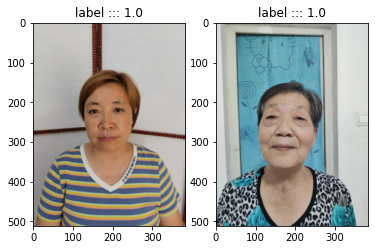

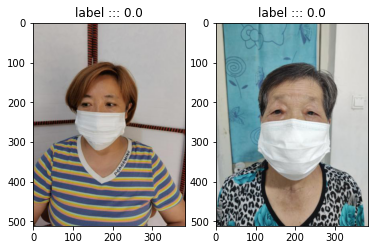

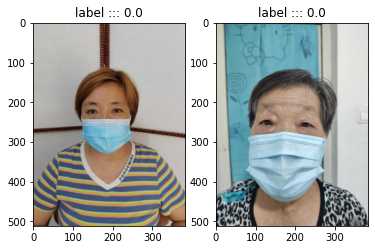

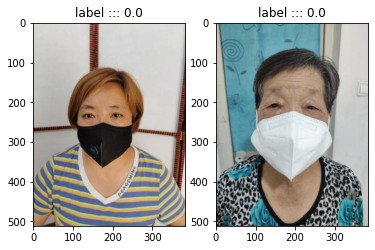

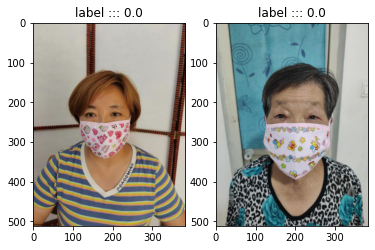

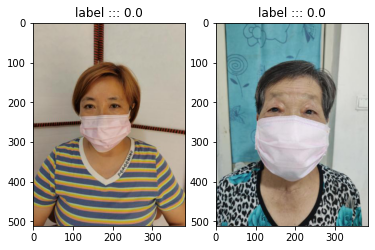

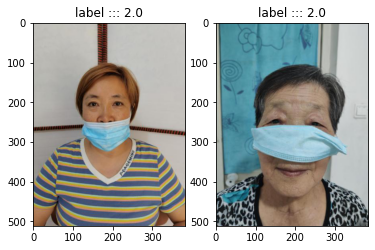

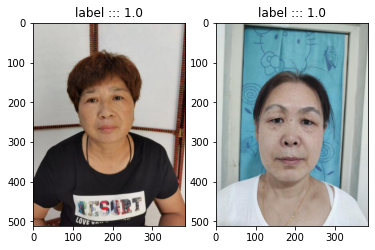

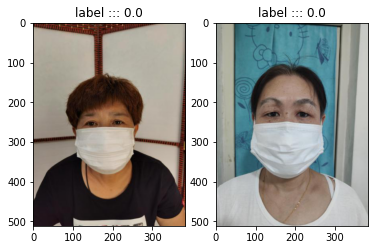

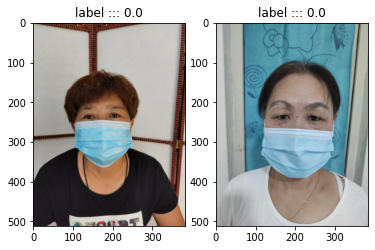

In [25]:
for i in range(10):
    fig, axes = plt.subplots(1, 2)
    image = tr_mask_dataset[i][0]
    label = tr_mask_dataset[i][1]

    axes[0].imshow(np.transpose(image,(1,2,0)))
    axes[0].set_title(f"label ::: {label}")
    
    image = val_mask_dataset[i][0]
    label = val_mask_dataset[i][1]

    axes[1].imshow(np.transpose(image,(1,2,0)))
    axes[1].set_title(f"label ::: {label}")
    

In [26]:
only_normal_dataset = MaskDataset(
    mode        = 'only_normal',
    train       = True,
    csv_path    = './train/train.csv',
    images_path = './train/images/',
    valid_ratio = 0.1,
    transforms  = T.ToTensor(),
)

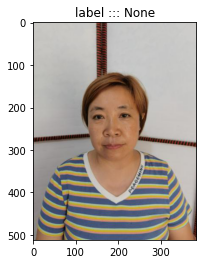

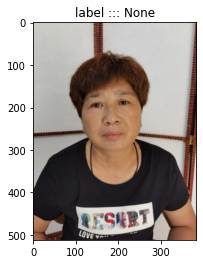

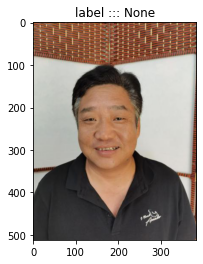

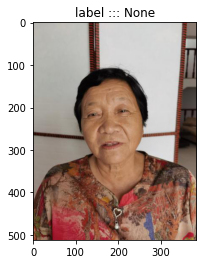

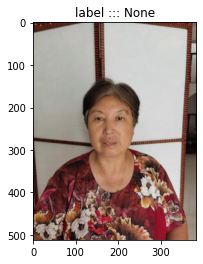

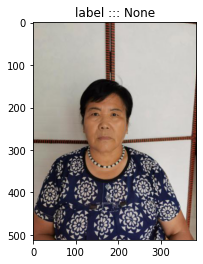

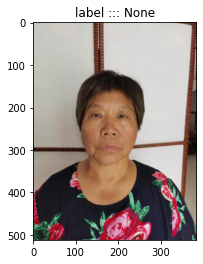

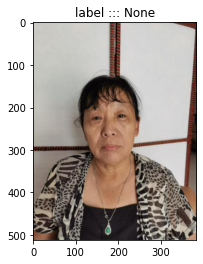

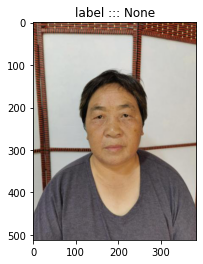

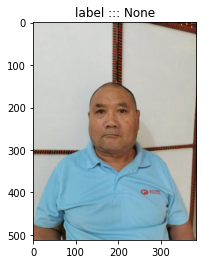

In [27]:
for i in range(10):
    fig, axes = plt.subplots(1, 1)
    image = only_normal_dataset[i][0]
    label = only_normal_dataset[i][1]

    axes.imshow(np.transpose(image,(1,2,0)))
    axes.set_title(f"label ::: {label}")
    